In [1]:
import pandas as pd
import os
import re
import numpy as np
from sentence_transformers import SentenceTransformer
import multiprocess 
from multiprocess import cpu_count
from multiprocess import Pool


In [2]:
path_ocrs = os.path.abspath("../datasets/predict_categories_dataset_ocrs.jsonl.gz")
path_products = os.path.abspath("../datasets/predict_categories_dataset_products.jsonl.gz")


In [125]:
def get_main_lang(dict_list):
    """ get the language that has the highest confidence in 'detectedLanguages' """
    max_v = 0
    main_lang = "not_found"
    for dict_ in dict_list:
        lang = dict_["languageCode"]
        if "confidence" in dict_:
            confidence = dict_["confidence"]
        else: confidence = -1
        if confidence > max_v:
            max_v = confidence
            main_lang = lang
    return main_lang, max_v


def get_row_for_df(json_line):
    """ extract items from json and returns a row to put in a dataframe """
    code = json_line['code']
    if "ocrs" in json_line:
        langs = []
        confidences = []
        texts = []
        keys =  list(json_line['ocrs'].keys())
        for key in keys:
            ocr_text = json_line['ocrs'][key]['text']
            detected_langs = json_line['ocrs'][key]['detectedLanguages']
            main_lang, confidence = get_main_lang(detected_langs)
            texts.append(ocr_text)
            langs.append(main_lang)
            confidences.append(confidence)
    row = [code, "<end_of_text> \n".join(texts),  confidences, langs, keys]
    return row

In [126]:
import gzip
import json
rows = []
with gzip.open(path_ocrs) as f:
    for i, line in enumerate(f):
        json_line = json.loads(line)
        row = get_row_for_df(json_line)
        rows.append(row)
df = pd.DataFrame(rows, columns = ["code", "texts", "confidences", "langs", "keys"])

In [132]:
filtr = (df["langs"].str.len()> 10)
df[filtr]


,code,texts,confidences,langs,keys
2635,0016000502666,Erdnisse und Schalenfrüchte enthalten.\nRSTete...,"[0.26, 0.95, 0.26, 0.62, 0.3, 0.26, 0.45, 0.26...","[sv, en, de, fr, en, sv, sv, sv, fr, en, de]","[13, 12, 16, 15, 4, 7, 18, 14, 3, 17, 6]"
3935,0022314010025,ETS CLEMENT FAUGIER\nLE LOGIS DU ROY - 07000 P...,"[0.64, 0.45, 0.54, 0.74, 1, 0.56, 0.72, 0.83, ...","[fr, en, en, fr, en, fr, fr, en, fr, fr, fr, fr]","[38, 47, 12, 43, 41, 46, 42, 11, 44, 3, 40, 45]"
7464,00343299,NUTRITION Typical values/aleurs\nmoyennes/Prům...,"[0.35, 0.5, 0.85, 0.61, 0.81, 1, 0.76, 0.79, 1...","[cs, nl, en, en, en, en, en, en, fr, en, fr]","[5, 8, 12, 11, 9, 10, 7, 3, 13, 4, 6]"
19337,0078895126389,"Ingrediënten: Water, zout, kleurstof\n(karamel...","[0.27, 1, 0.86, 0.65, 0.93, 0.34, 0.61, 0.39, ...","[fr, fr, de, en, en, de, en, en, en, de, en]","[13, 5, 12, 16, 15, 19, 18, 14, 9, 11, 17]"
24705,0602652176753,Nutritional information typical values/Inforrm...,"[0.24, 0.34, 0.68, 0.52, 0.6, 0.66, 0.65, 0.64...","[lb, nl, fr, en, sv, sv, de, sv, en, it, no, en]","[13, 21, 17, 24, 23, 22, 16, 15, 10, 18, 25, 14]"
...,...,...,...,...,...
732828,4337256148450,%-RM**\npro 100g pro 100g\n%-RM**\nDurchschnit...,"[0.34, 1, 0.34, 0.34, 0.34, 0.34, 0.34, 0.34, ...","[de, de, de, de, de, de, de, de, de, de, de, de]","[5, 2, 9, 11, 7, 4, 8, 12, 10, 1, 3, 6]"
733748,3270160866298,8 %%一%%\nA Na 4 |52\n242105-P15616\nV1 de 08/2...,"[0.4, 0.44, 0.32, 0.64, 0.37, 0.49, 0.46, 0.52...","[sv, fr, fr, fr, fr, fr, fr, fr, fr, sv, fr]","[8, 5, 9, 11, 10, 7, 4, 1, 3, 2, 6]"
734810,3083681149852,Energie\nMatières grasses\ndont acides gras sa...,"[0.61, 0.66, 0.64, 0.86, 0.54, 0.66, 0.66, 0.6...","[fr, fr, fr, fr, fr, fr, fr, fr, fr, fr, fr, f...","[5, 13, 12, 11, 2, 7, 3, 8, 9, 15, 10, 1, 4, 1..."
757370,8480000236432,E MEDIOS/\n00g\npor pon/\nIR*I DR\nporção ue 2...,"[0.38, 0.45, 0.43, 0.8, 0.4, 0.41, 0.33, 0.35,...","[es, es, es, es, es, es, es, es, es, es, es]","[8, 5, 9, 11, 2, 7, 3, 1, 10, 4, 6]"


In [198]:
c = df.loc[2635, "confidences"]
l = df.loc[2635, "langs"]
print(df.loc[2635, "confidences"])
print(df.loc[2635, "langs"])
print(df.loc[2635, "keys"])

[0.26, 0.95, 0.26, 0.62, 0.3, 0.26, 0.45, 0.26, 0.72, 0.78, 0.36]
['sv', 'en', 'de', 'fr', 'en', 'sv', 'sv', 'sv', 'fr', 'en', 'de']
['13', '12', '16', '15', '4', '7', '18', '14', '3', '17', '6']


In [202]:
lang_to_use = get_most_confident_lang(c, l, df.loc[2635, "texts"])
np.where(l ==lang_to_use)


(array([], dtype=int64),)

In [209]:
print(" ".join([df.loc[2635, "texts"].split("<end_of_text> \n")[i] for i in  np.where( np.array(l) ==lang_to_use)[0]]))

42ge
oquantes à l'avoine complète et au miel. Ingrédients:
arbonate de sodium). Allergènes: voir les ingrédients
nit
tor
For UK only
en,
ch
ikt
tor
en
Don't
Recycle
F
F FRANCE ONLY
 oey (296), Sall, old
contain peanut, tree nuts and soy ingredients. FR Barre croquante à l'avoine complète et au miel. Ingrédients: avoine complète
(59%), sucre, huile de tournesol, miel (2%), sel, mélasse, émulsifiant: lécithine de tournesol, poudre à lever: bicarbonate de sodium.
Allergènes: voir les ingrédients en gras. Peut contenir des ingrédients à base de cacahuètes, de fruits à coques et de soja. DE Knu
Vollkorn-Haferflocken und Honig. Zutaten: Vollkorn-Haferflocken (59%), Zucker, Sonnenblumenöl, Honig (2%) , Speisesalz,
Schale



In [193]:
def floor(x:int)->int:
    if x >= 1000:
        x = 1000
    return x

def get_most_confident_lang(confidences, langs, texts):
    """
    get the language that has a good balance between confidence and length
    score = confidence_mean * text_len. if text_len > 1000 then text_len = 1000
    """
    D = {}
    for conf, lang, text in zip(confidences, langs, texts.split("<end_of_text> \n")):
        if lang in D:
            D[lang]["confidences"].append(conf)
            D[lang]["text_len"] += len(text)
        else:
            D[lang] = {}
            D[lang]["confidences"] = [conf]
            D[lang]["text_len"] = len(text)
    output_dict = {lang: np.mean(D[lang]['confidences'])*floor(D[lang]['text_len']) for lang in D}
    return max(output_dict, key = output_dict.get)

In [33]:
print(json_line['ocrs']["2"]["text"])

KeyError: '2'

In [4]:
lang_value_counts = df["lang"].value_counts()
filtr = (lang_value_counts > 30)
langs_to_keep = lang_value_counts[filtr].index
filtr = df["lang"].isin(langs_to_keep)
df = df[filtr]


In [5]:
df.loc[0,"text"]

"COCONUT\nBEE\n1\n100%\nNATURAL\nPollen\nparbe\n RESEALABLE\nReese's\nWHITE\nmini CuPS\nUNWRAPPED MINI WHITE\nPEANUT BUTTER CUPS\nPER 9 PIECE SERVING\n170T 5\nCALDRIESSAT FAT SODIUM TOTAL\n90mg\n24/ DV 40/V SUGARS\n"

In [6]:
def text_cleaner(text):
  text_cleaned = text.replace("\n", " ") #remove line breaks
  text_cleaned = re.sub("\w*([.])\w+", "", text_cleaned) #remove websites
  #text_cleaned = re.sub("\w*([0-9],[0-9])\w*", "", text_cleaned) #remove measure elements
  #text_cleaned = re.sub("\w*([0-9].[0-9])\w*", "", text_cleaned) #remove measure elements
  #text_cleaned = re.sub(r"\b([a-zA-Z]{1})\b", "", text_cleaned) # remove isolated letters ex --> g g g g g
  text_cleaned = re.sub(r" +", " ", text_cleaned) # remove multiple spaces

  text_cleaned = "".join([ch for ch in text_cleaned if (ch.isalnum() or ch == " " or ch =="'" or ch =="-")])
  return text_cleaned

In [7]:
from tqdm import tqdm
def worker_cleaner(list_):
    return [text_cleaner(x) for x in list_]

def chunk_worker(chunk):
    text_cleaned_col_idx = np.where(df.columns == "text_cleaned")[0][0]
    text_list = df.iloc[chunk, text_cleaned_col_idx]
    return worker_cleaner(text_list)


In [12]:
chunks = np.array_split(range(df.shape[0]), cpu_count())
print(len(chunks))
print(len(chunks[0]))

4
109750


In [15]:
pool = Pool()
multiple_results = [pool.apply_async(chunk_worker, (chunks[i],)) for i in range(cpu_count())]
output = [r.get() for r in multiple_results]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [16]:
df["text_cleaned"] = df["text"].apply(lambda x : text_cleaner(x))

print(df.loc[0, "text"])
print("----")
print(df.loc[0, "text_cleaned"])

COCONUT
BEE
1
100%
NATURAL
Pollen
parbe
 RESEALABLE
Reese's
WHITE
mini CuPS
UNWRAPPED MINI WHITE
PEANUT BUTTER CUPS
PER 9 PIECE SERVING
170T 5
CALDRIESSAT FAT SODIUM TOTAL
90mg
24/ DV 40/V SUGARS

----
COCONUT BEE 1 100 NATURAL Pollen parbe RESEALABLE Reese's WHITE mini CuPS UNWRAPPED MINI WHITE PEANUT BUTTER CUPS PER 9 PIECE SERVING 170T 5 CALDRIESSAT FAT SODIUM TOTAL 90mg 24 DV 40V SUGARS 


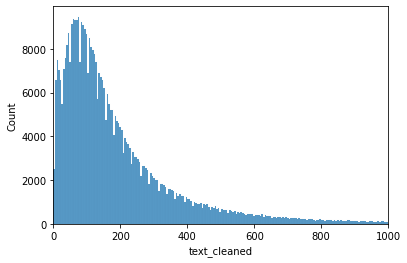

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
word_count = df['text_cleaned'].str.split().str.len()
sns.histplot(word_count)
plt.xlim([0,1000])
plt.show()


In [18]:
print(df.shape)
df["word_count"] = word_count
filtr = word_count >= 5
i = np.random.choice(range(df.loc[~filtr, "text_cleaned"].shape[0]))
print(df.loc[~filtr, "text_cleaned"].iloc[i])
df = df[filtr]
print(df.shape)


(439000, 4)
100 Саpрy 100 ПОРТОКАЛ 
(436485, 5)


### TFIDF Trick

In [19]:
#fit on the whole french dataset
from sklearn.feature_extraction.text import TfidfVectorizer
df_fr = df[df["lang"]== "fr"]
print(df_fr.shape)


(236517, 5)


In [25]:
i = np.random.choice(range(df_fr.shape[0]))
print(i)
print(df_fr["text_cleaned"].iloc[i])


70138
BLISSTARSON Rou BRE NE Sepece ensoleillee qui relėve le goût de la soupe de poisson elhause une mayonnaise pour vos viandes poissons ou ceufs durs ingredientsEauhuile de tournesol concentré de tomate oignons frai's beurre ail poudre harissa amidon transformé de mais sel Pule doliveproteines de lait épaississant carraghénane herbe de Valeurs nutritionn les pour 100 g Energie 778 kl188 kcal ntSores 18g-P ines 21 g- Sel 15 g Prowencepiment fort Motieres grasses 17 dont acides gras saturés 4 g-Glucides 59g ines 21g-Sel 15 g 1d 


In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents="ascii", min_df = 2, max_df = 0.6)
tfidf_matrix_fr = vectorizer.fit_transform(df_fr["text_cleaned"])
tfidf_matrix_fr

<236517x475137 sparse matrix of type '<class 'numpy.float64'>'
	with 24160250 stored elements in Compressed Sparse Row format>

In [113]:
def get_words_with_highest_scores(scores, words, n_words_to_take):
  """
  takes scores and words of an OCR as inputs and returns 
  words with highest tfidf scores
  """
  items = [item for item in sorted(zip(scores, words), reverse = True)]
  best_items = items[:n_words_to_take]
  return best_items, items

def get_words_and_scores_from_tfidf_matrix(doc, cols, tfidf_matrix_fr, index_to_word):
  """
  takes a document (line of tfidf matrix) and its words (columns of tfidf matrix
  and returns words of the documents with their ifidf scores
  columns are the non zero values of the tfidf matrix.
  """
  scores = []
  words = []
  for col in cols:
    word = index_to_word[col] 
    score = tfidf_matrix_fr[doc, col]
    words.append(word)
    scores.append(score)
  return words, scores

index_to_word = {index: word for index, word in zip(vectorizer.vocabulary_.values(), vectorizer.vocabulary_.keys())}

def text_selection(doc, index_to_word, df_cleaned, n_words_to_take = 35):
  rows, cols = tfidf_matrix_fr[doc].nonzero()
  ## extract words and scores from tfidf matrix
  words, scores = get_words_and_scores_from_tfidf_matrix(doc, cols, tfidf_matrix_fr, index_to_word)
  #extract words with highest score from sentence
  best_items, items = get_words_with_highest_scores(scores, words, n_words_to_take)
  best_words = [item[1] for item in best_items]
  text_selection = " ".join([word for word in df_cleaned.iloc[doc].split() if word.lower() in best_words])
  text_selection_unique = remove_duplicates(text_selection)
  return text_selection_unique, items

In [42]:
def remove_duplicates(text):
    D = {word.lower(): word  for word in str(text).split()}
    return " ".join(D.values())

In [47]:
freq_dict = {}
for text in tqdm(df_fr["text_cleaned"]):
    for word in remove_duplicates(text).split():
        if str(word).lower() in freq_dict:
            freq_dict[str(word).lower()] += 1
        else:
            freq_dict[str(word).lower()] =1

100%|██████████| 236517/236517 [01:08<00:00, 3468.42it/s]


In [94]:
freq_dic_sorted = {k: v for k, v in sorted(freq_dict.items(), reverse = True, key=lambda item: item[1]) if v > 1}
thresh = int(len(freq_dic_sorted)*0.01)
selection = freq_dic_sorted.keys()
selection = list(selection)[15:]
len(selection)

546513

In [116]:
text_selection(0, index_to_word, df_fr["text_cleaned"], n_words_to_take = 15)

('21',
 [(0.12722778359618755, 'sugan'),
  (0.11768972967266439, 'jamboh'),
  (0.11701390900066326, 'erythortbate'),
  (0.11185536081827076, 'porbon'),
  (0.1110763967833102, 'lijnzaden'),
  (0.1099948702356461, '21'),
  (0.10336522928487146, 'clementina'),
  (0.09139463985474837, 'frien'),
  (0.09108569990292426, 'oeye'),
  (0.08965174392726537, 'goutpas'),
  (0.08964911600897654, 'kcail'),
  (0.0891069155484169, 'energetiqu'),
  (0.08765554816198107, 'bourgognc'),
  (0.08451248098494, 'clementinensaft'),
  (0.08340600504134636, 'whhs'),
  (0.08322911186111019, '100g'),
  (0.08263627271775145, 'persilja'),
  (0.08223758900119574, 'binve'),
  (0.08208921205130684, '990114'),
  (0.08208921205130684, '4088g'),
  (0.08208921205130684, '4071g'),
  (0.08088042268421808, 'naturaie'),
  (0.0803743154611481, 'comteregoit'),
  (0.08016536090846471, '16649'),
  (0.0767761855921819, 'and'),
  (0.07622784175473131, 'franccois'),
  (0.07613701527866709, '100'),
  (0.07474232912223999, 'toosts'),
  

In [33]:
df_fr_text_cleaned_word_selection = [text_selection(i, index_to_word, df_fr["text_cleaned"])[0] for i in range(df_fr.shape[0]))]

KeyboardInterrupt: 

In [ ]:
df_fr["word_selection"] = df_fr_text_cleaned_word_selection